## Emotion Recognition using Facial Landmarks, Python, DLib and OpenCV
Relatório referente ao T3 da disciplina IA369Y - Computação afetiva.  
Prof. Dra. Paula Dornhofer Paro Costa  
Aluno: Nathan Gustavo Vieira Ribeiro RA263732  

# Objetivo da tarefa
O objetivo da atividade 6 era de executar o tutorial "Emotion Recognition using Facial Landmarks, Python, DLib and OpenCV" escrito por Paul van Gent, pesquisador da Delft University of Technology. O autor inicia o artigo descrevendo sobre as ferramentas necessárias para realizar a detecção de emoções em imagens sendo as seguintes:  
* Python (Linguagem de programação utilizada para o desenvolvimento do algoritmo proposto pelo autor);
* OpenCV (Biblioteca de Visão Computacional que comporta diferentes funções para análises de imagem/vídeo);
* SKLearn (Biblioteca com ferrametas para Machine Learning em Python);
* Dlib (Biblioteca implementada em C++ com interfaces em Python, com diferentes ferramentas de Machine Learning e Análise de Dados, muito utilizada para a detecção de faces);
* Visual Studio 2015 (Utilizado no contexto do artigo para a compilação do Dlib, não foi necessária a instalação do mesmo no meu sistema operacional);

# Instalação de Dependências e primeiros problemas

Como o artigo data de 2016, não existiam maneiras mais simples de realizar a instalação/compilação das dependências do Dlib sem que o mesmo fosse compilado diretamente pelo usuário. Com a evolução da ferramenta não é mais necessário realizar a compilação manual da biblioteca. Fiz a instalação das dependências do sistema operacional e do setup facilitado da biblioteca com os comandos abaixo:
* sudo apt-get install build-essential cmake pkg-config  
* sudo apt-get install libx11-dev libatlas-base-dev  
* sudo apt-get install libgtk-3-dev libboost-python-dev

Em seguida fiz a instalação das bibliotecas e dependências necessárias para funcionamento utilizando o gerenciador de dependências do Python (pip). Tive problemas de exeutar a instalação do Dlib diretamente pelo Jupyter Notebook. Como o processo do arquivo de setup gerado pela biblioteca do Dlib faz todas as etapas descritas pelo autor automaticamente, a mesma demanda grande quantidade de memória RAM e CPU da máquina e ocasionava o travamento do Jupyter Notebook sendo necessária a instalação manual da biblioteca diretamente no terminal do sistema operacional.

Os comandos que devem ser executados para a instalação das dependências são descritos abaixo (O bloco está comentado para evitar a execução desnecessária do bloco após pré instalação. 

In [1]:
import sys
#!{sys.executable} -m pip install opencv-python
#!{sys.executable} -m pip install sklearn
#!{sys.executable} -m pip install dlib

No primeiro exemplo cujo código é apresentado abaixo, o autor mostra a importação da biblioteca do Dlib e do OpenCV e com base em um detector de faces da bibliotca Dlib e no preditor de pontos característicos da face ele faz a plotagem dos pontos utilizando o OpenCV.

 *** O código abaixo está comentado pois a execução do mesmo no Jupyter Notebook pode gerar algumas falhas.**

In [2]:
#import cv2
#import dlib

#video_capture = cv2.VideoCapture(0)
#detector = dlib.get_frontal_face_detector()
#predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
#while True:
#    ret, frame = video_capture.read()
#    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
#    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
#    clahe_image = clahe.apply(gray)
#    detections = detector(clahe_image, 1) #Detect the faces in the image
#    for k,d in enumerate(detections): #For each detected face
#        shape = predictor(clahe_image, d) #Get coordinates
#        for i in range(1,68): #There are 68 landmark points on each face
#            cv2.circle(frame, (shape.part(i).x, shape.part(i).y), 1, (0,0,255), thickness=2) #For each point, draw a red circle with thickness2 on the original frame
#    cv2.imshow("image", frame) #Display the frame
#    if cv2.waitKey(1) & 0xFF == ord('q'): #Exit program when the user presses 'q'
#        break

O resultado do código acima é apresentado na seguinte imagem.

![Teste com a detecção de Landmarks na Webcam](img/1.png)


# Extraindo Features da Face
O autor comenta que o primeiro passo para utilizar estes pontos da face para treinamentos é transformá-los em features, os pontos da face são extremamente úteis para a detecção de emoções pois se tratam das principais "partes móveis" da face durante a expressão das mesmas.

O bloco de código abaixo define a função que é responsável por realizar a detecção dos "landmarks" da face e extraí-los em features que poderão se utilizadas futuramente para a classificação dos dados.

In [3]:
import cv2
import dlib
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
def get_landmarks(image):
    detections = detector(image, 1)
    for k,d in enumerate(detections): #For all detected face instances individually
        shape = predictor(image, d) #Draw Facial Landmarks with the predictor class
        xlist = []
        ylist = []
        for i in range(1,68): #Store X and Y coordinates in two lists
            xlist.append(float(shape.part(i).x))
            ylist.append(float(shape.part(i).y))
        for x, y in zip(xlist, ylist): #Store all landmarks in one list in the format x1,y1,x2,y2,etc.
            landmarks.append(x)
            landmarks.append(y)
    if len(detections) > 0:
        return landmarks
    else: #If no faces are detected, return error message to other function to handle
        landmarks = "error"
        return landmarks

O arquivo .dat utilizado para a detecção dos pontos característicos da face é um modelo pré-treinado sendo possível de ser adquirido no [seguinte link](http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2). 

O autor explica que aplicar uma normalização das coordenadas X e Y dos pontos da face em uma escala de 0 – 1 é inefetivo pela alta probabilidade de ocorrem falsos positivos/negativos no contexto da detecção das emoções por serem “shapes” muito próximos para emoções totalmente opostas. A fómula para realizar esta normalização simples é a seguinte:

$$
X_{norm} = \frac{X - X_{min}}{ X_{max} - X_{min}}
$$

Ele propõe a criação de um ponto de referência central que é calculado pela média de ambos os eixos, isto resulta em um ponto relativo ao centro da face o qual ele chama de “centro de gravidade” dos pontos detectados na face.

Com o “centro de gravidade” definido ele então propõe que os pontos sejam ligados em uma reta ou vetor com o ponto central e suas correlações/distâncias e comenta que adotar o método de “centro de gravidade” é mais efetivo que utilizar a ponta do nariz como referência para a criação destes vetores pela subjetividade de posições/ângulos que as faces podem apresentar e que dificultam sobremaneira uma análise objetiva, ainda comenta que a estratégia adotada por ele em seu modelo possibilita uma correção aplicando um coeficiente angular cujo objetivo é aproximar ao máximo ao ângulo 0º do “centro de gravidade” da face.

Deste modo a função que faz a detecção dos pontos característicos considerando as correções adotadas pelo "centro de gravidade" é descrita a seguir:

In [4]:
def get_landmarks(image):
    detections = detector(image, 1)
    for k,d in enumerate(detections): #For all detected face instances individually
        shape = predictor(image, d) #Draw Facial Landmarks with the predictor class
        xlist = []
        ylist = []
        for i in range(1,68): #Store X and Y coordinates in two lists
            xlist.append(float(shape.part(i).x))
            ylist.append(float(shape.part(i).y))
        xmean = np.mean(xlist) #Find both coordinates of centre of gravity
        ymean = np.mean(ylist)
        xcentral = [(x-xmean) for x in xlist] #Calculate distance centre <-> other points in both axes
        ycentral = [(y-ymean) for y in ylist]
        landmarks_vectorised = []
        for x, y, w, z in zip(xcentral, ycentral, xlist, ylist):
            landmarks_vectorised.append(w)
            landmarks_vectorised.append(z)
            meannp = np.asarray((ymean,xmean))
            coornp = np.asarray((z,w))
            dist = np.linalg.norm(coornp-meannp)
            landmarks_vectorised.append(dist)
            landmarks_vectorised.append((math.atan2(y, x)*360)/(2*math.pi))
        data['landmarks_vectorised'] = landmarks_vectorised
    if len(detections) < 1:
        data['landmarks_vestorised'] = "error"

O próximo passo é treinar um modelo de classificação para detectar a emoção das imagens da face, ele propõe a utilização de um modelo SVM cujo objetivo é separar as classes dos objetos por meio de hiperplanos que melhor descrevam cada um dos rótulos a serem classificados.

Entretanto para que seja possível realizar o treinamento do modelo de classificação é necessário realizar a limpeza dos Datasets que serão analisados, ele propõe que utilizemos os dados que são descritos em uma postagem anterior de seu blog denominada ["Emotion Recognition With Python, OpenCV and a Face Dataset"](http://www.paulvangent.com/2016/04/01/emotion-recognition-with-python-opencv-and-a-face-dataset/).

# Preparação dos Datasets

O autor recomenda a utilização do Dataset Cohn-Kanade Extended[1], o mesmo é disponibilizado gratuitamente para fins acadêmicos e deve ser requisitado mediante aceitação de uso [neste link](http://www.consortium.ri.cmu.edu/ckagree/).

No arquivo de Readme da base de dados, o autor menciona que apenas um subconjunto (327 de 593) de dados possuí os arquétipos emocionais completos. Cada sequência de imagem é referente a uma seção com um participante da coletânea de imagens e consiste em uma imagem referênte a cada uma das emoções contidas na base (anger, contempt, disgust, fear, happy, neutral, sadness e surprise).

Como cada uma das sequências está contida numa subpasta o autor criou um script que percorre cada pasta das seções, localizadas na estrutura de pastas descrita abaixo:
* source_emotion
    * 586 **#Id do participante**
        * anger_image.png **# fotografia do participante no estado emocional**
        * contempt_image.png
        * ...
    * ...

E organiza as imagens na seguinte estrutura*:
* sorted_set
    * anger
    * contempt
    * disgust
    * fear
    * happy
    * neutral
    * sadness
    * surprise

[1] Lucey, P., Cohn, J. F., Kanade, T., Saragih, J., Ambadar, Z., & Matthews, I. (2010). The Extended Cohn-Kanade Dataset (CK+): A complete expression dataset for action unit and emotion-specified expression. Proceedings of the Third International Workshop on CVPR for Human Communicative Behavior Analysis (CVPR4HB 2010), San Francisco, USA, 94-101.

***As pastas não são criadas automaticamente sendo necessário criá-las/organizá-las manualmente.**

O script é apresentado no bloco abaixo:

In [5]:
import glob
from shutil import copyfile

emotions = ["neutral", "anger", "contempt", "disgust", "fear", "happy", "sadness", "surprise"] #Define emotion order
participants = glob.glob("source_emotion\\*") #Returns a list of all folders with participant numbers

for x in participants:
    part = "%s" %x[-4:] #store current participant number
    for sessions in glob.glob("%s\\*" %x): #Store list of sessions for current participant
        for files in glob.glob("%s\\*" %sessions):
            current_session = files[20:-30]
            file = open(files, 'r')
            
            emotion = int(float(file.readline())) #emotions are encoded as a float, readline as float, then convert to integer.
            
            sourcefile_emotion = glob.glob("source_images\\%s\\%s\\*" %(part, current_session))[-1] #get path for last image in sequence, which contains the emotion
            sourcefile_neutral = glob.glob("source_images\\%s\\%s\\*" %(part, current_session))[0] #do same for neutral image
            
            dest_neut = "sorted_set\\neutral\\%s" %sourcefile_neutral[25:] #Generate path to put neutral image
            dest_emot = "sorted_set\\%s\\%s" %(emotions[emotion], sourcefile_emotion[25:]) #Do same for emotion containing image
            
            copyfile(sourcefile_neutral, dest_neut) #Copy file
            copyfile(sourcefile_emotion, dest_emot) #Copy file

Em seguida é necessário extrair as faces destas imagens, para tal o autor utiliza filtros de Haar disponíveis na biblioteca OpenCV que provê 4 modelos de classificadores pré-treinados disponíveis [neste link](http://www.paulvangent.com/wp-content/uploads/2016/04/OpenCV_FaceCascade.zip).

É necessário criar manualmente uma pasta chamada "dataset" e criar as subpastas referentes a cada uma das emoções, os dados extraídos serão inseridos nestas pastas. O autor ainda comenta que é necessário realizar uma limpeza da pasta "neutral" pois como cada participante apresentou mais de uma expressão para cada emoção, existem mais de uma imagem neutra para cada pessoa, o autor propõe que a limpeza desta pasta seja feita manualmente até que somente uma imagem de cada pessoa esteja dentro do conjunto de imagens neutras. 

O código para realizar essa separação é apresentado abaixo:

In [6]:
import cv2
import glob
faceDet = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
faceDet_two = cv2.CascadeClassifier("haarcascade_frontalface_alt2.xml")
faceDet_three = cv2.CascadeClassifier("haarcascade_frontalface_alt.xml")
faceDet_four = cv2.CascadeClassifier("haarcascade_frontalface_alt_tree.xml")
emotions = ["neutral", "anger", "contempt", "disgust", "fear", "happy", "sadness", "surprise"] #Define emotions
def detect_faces(emotion):
    files = glob.glob("sorted_set\\%s\\*" %emotion) #Get list of all images with emotion
    filenumber = 0
    for f in files:
        frame = cv2.imread(f) #Open image
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) #Convert image to grayscale
        #Detect face using 4 different classifiers
        face = faceDet.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(5, 5), flags=cv2.CASCADE_SCALE_IMAGE)
        face_two = faceDet_two.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(5, 5), flags=cv2.CASCADE_SCALE_IMAGE)
        face_three = faceDet_three.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(5, 5), flags=cv2.CASCADE_SCALE_IMAGE)
        face_four = faceDet_four.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(5, 5), flags=cv2.CASCADE_SCALE_IMAGE)
        #Go over detected faces, stop at first detected face, return empty if no face.
        if len(face) == 1:
            facefeatures = face
        elif len(face_two) == 1:
            facefeatures = face_two
        elif len(face_three) == 1:
            facefeatures = face_three
        elif len(face_four) == 1:
            facefeatures = face_four
        else:
            facefeatures = ""
        #Cut and save face
        for (x, y, w, h) in facefeatures: #get coordinates and size of rectangle containing face
            print("face found in file: %s" %f)
            gray = gray[y:y+h, x:x+w] #Cut the frame to size
            try:
                out = cv2.resize(gray, (350, 350)) #Resize face so all images have same size
                cv2.imwrite("dataset\\%s\\%s.jpg" %(emotion, filenumber), out) #Write image
            except:
               pass #If error, pass file
        filenumber += 1 #Increment image number
for emotion in emotions:
    detect_faces(emotion) #Call functiona

# Criando e treinando o modelo

O primeiro passo é preparar os datasets para o treinamento do modelo de detecção das emoções, ele propõe a divisão de 80% dos dados para treinamento e 20% para teste.

Como já dito anteriormente o autor propõe a utilização de um modelo SVM para a separação das classes dos objetos por meio de hiperplanos que melhor descrevam cada um dos rótulos emocionais. O código abaixo apresenta o código necessário para preparar os datasets de treinamento e de teste e realizar o treinamento do modelo, ao fim ele ainda apresenta a acurácia média do modelo treinado:

In [7]:
import cv2
import os
import glob
import random
import math
import numpy as np
import dlib
import itertools
from sklearn.svm import SVC
emotions = ["anger", "happy", "neutral", "sadness", "surprise"] #Emotion list
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat") #Or set this to whatever you named the downloaded file
clf = SVC(kernel='linear', probability=True, tol=1e-3)#, verbose = True) #Set the classifier as a support vector machines with polynomial kernel
data = {} #Make dictionary for all values
#data['landmarks_vectorised'] = []
def get_files(emotion): #Define function to get file list, randomly shuffle it and split 80/20
    files = glob.glob('dataset/%s/*' %emotion) #Alterei essa linha
    random.shuffle(files)
    training = files[:int(len(files)*0.8)] #get first 80% of file list
    prediction = files[-int(len(files)*0.2):] #get last 20% of file list
    return training, prediction
def get_landmarks(image):
    detections = detector(image, 1)
    for k,d in enumerate(detections): #For all detected face instances individually
        shape = predictor(image, d) #Draw Facial Landmarks with the predictor class
        xlist = []
        ylist = []
        for i in range(1,68): #Store X and Y coordinates in two lists
            xlist.append(float(shape.part(i).x))
            ylist.append(float(shape.part(i).y))
        xmean = np.mean(xlist)
        ymean = np.mean(ylist)
        xcentral = [(x-xmean) for x in xlist]
        ycentral = [(y-ymean) for y in ylist]
        landmarks_vectorised = []
        for x, y, w, z in zip(xcentral, ycentral, xlist, ylist):
            landmarks_vectorised.append(w)
            landmarks_vectorised.append(z)
            meannp = np.asarray((ymean,xmean))
            coornp = np.asarray((z,w))
            dist = np.linalg.norm(coornp-meannp)
            landmarks_vectorised.append(dist)
            landmarks_vectorised.append((math.atan2(y, x)*360)/(2*math.pi))
        data['landmarks_vectorised'] = landmarks_vectorised
    if len(detections) < 1:
        data['landmarks_vestorised'] = "error"
def make_sets():
    training_data = []
    training_labels = []
    prediction_data = []
    prediction_labels = []
    training_files = []
    prediction_files = []
    for emotion in emotions:
        print(" working on %s" %emotion)
        training, prediction = get_files(emotion)
        #Append data to training and prediction list, and generate labels 0-7
        for item in training:
            image = cv2.imread(item) #open image
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #convert to grayscale
            clahe_image = clahe.apply(gray)
            get_landmarks(clahe_image)
            if data['landmarks_vectorised'] == "error":
                print("no face detected on this one")
            else:
                training_data.append(data['landmarks_vectorised']) #append image array to training data list
                training_labels.append(emotions.index(emotion))
                training_files.append(item)
        for item in prediction:
            image = cv2.imread(item)
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            clahe_image = clahe.apply(gray)
            get_landmarks(clahe_image)
            if data['landmarks_vectorised'] == "error":
                print("no face detected on this one")
            else:
                prediction_data.append(data['landmarks_vectorised'])
                prediction_labels.append(emotions.index(emotion))
                prediction_files.append(item)
    return training_data, training_labels, prediction_data, prediction_labels, training_files, prediction_files
accur_lin = []
for i in range(0,1):
    print("Making sets %s" %i) #Make sets by random sampling 80/20%
    training_data, training_labels, prediction_data, prediction_labels, training_files, prediction_files = make_sets()
    
    npar_train = np.array(training_data) #Turn the training set into a numpy array for the classifier
    npar_trainlabs = np.array(training_labels)
    print("training SVM linear %s" %i) #train SVM
    clf.fit(npar_train, training_labels)
    print("getting accuracies %s" %i) #Use score() function to get accuracy
    npar_pred = np.array(prediction_data)
    pred_lin = clf.score(npar_pred, prediction_labels)
    print ("linear: ", pred_lin)
    accur_lin.append(pred_lin) #Store accuracy in a list
print("Mean value lin svm: %s" %np.mean(accur_lin)) #FGet mean accuracy of the 10 runs

Making sets 0
 working on anger
 working on happy
 working on neutral
 working on sadness
 working on surprise
training SVM linear 0
getting accuracies 0
linear:  0.7692307692307693
Mean value lin svm: 0.7692307692307693


Considerando todos os rótulos emocionais o algoritmo apresenta uma acurácia de aproximadamente 69,3%, se reduzirmos a quantidade dos rótulos para cinco (anger, happy, neutral, sadness, surprise), em minha execução consegui chegar a 87% como é possível observar na imagem seguinte.

![Resultado original com o CK+](img/2.png)

# Verificando as features e analisando os erros 

O código abaixo têm como objetivo realizar a análise das previsões, para tal modifiquei um pouco o código responsável por gerar os Sets de dados para que o mesmo retorne uma lista dos nomes dos arquivos te teste e treinamento, deste modo é possível realizar uma análise caso a caso.

Este código verifica para cada um dos arquivos que foram selecionados para o teste do modelo quais os rótulos emocionais preditos e quais os rótulos corretos para cada imagem, e em seguida apresenta as probabilidades para cada uma das imagens.

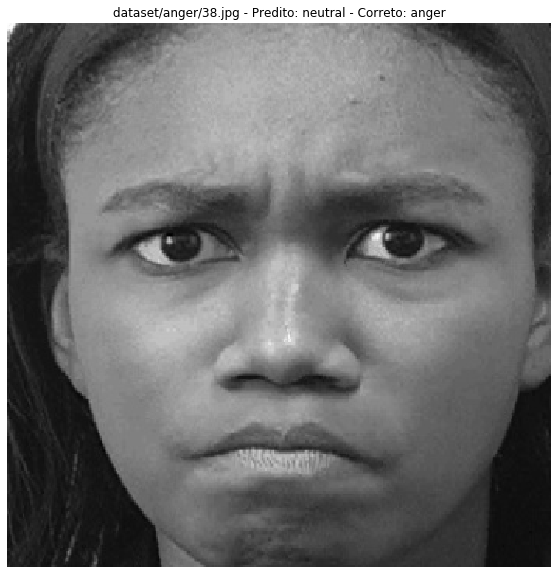

anger: 32.55%
happy: 0.71%
neutral: 33.75%
sadness: 31.34%
surprise: 1.65%


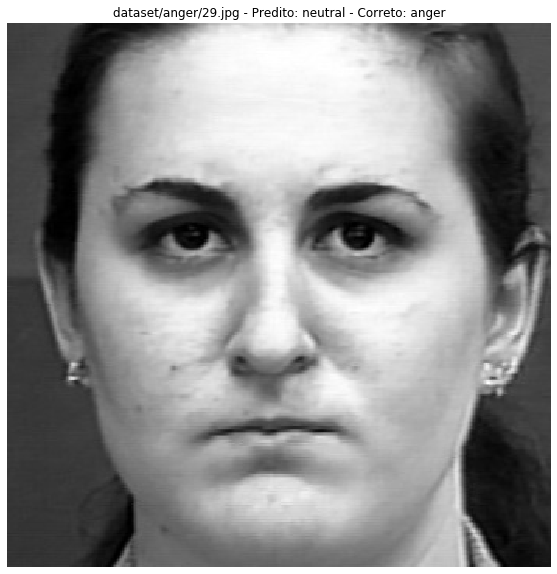

anger: 5.75%
happy: 1.71%
neutral: 61.70%
sadness: 10.81%
surprise: 20.02%


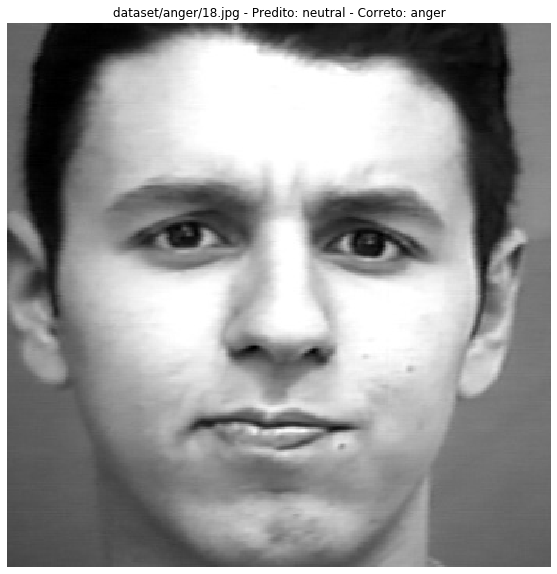

anger: 28.82%
happy: 17.11%
neutral: 43.11%
sadness: 7.05%
surprise: 3.91%


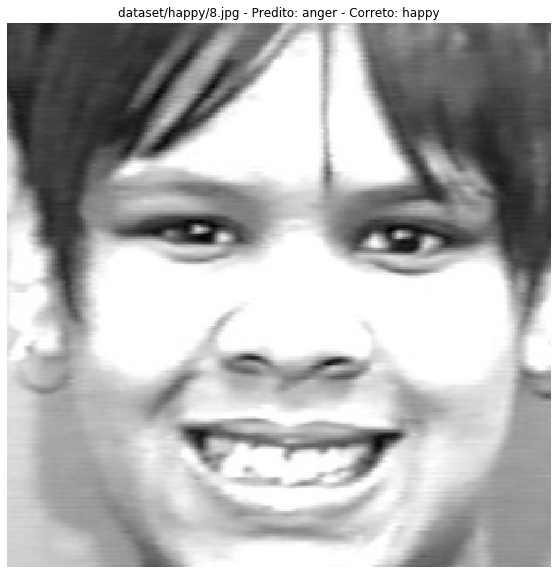

anger: 67.84%
happy: 23.80%
neutral: 4.86%
sadness: 1.51%
surprise: 1.98%


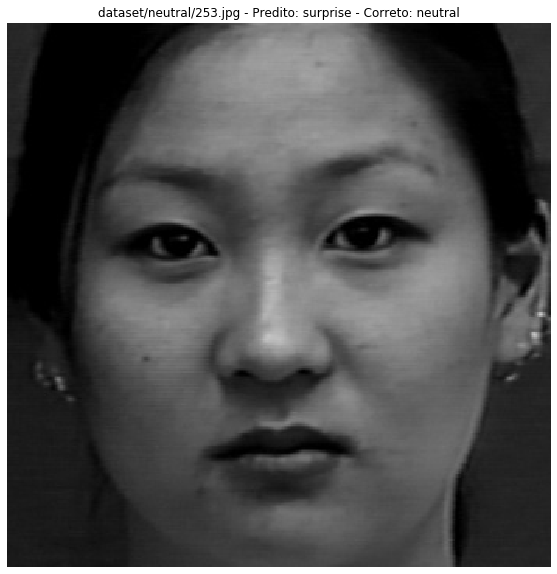

anger: 4.22%
happy: 0.73%
neutral: 16.19%
sadness: 8.98%
surprise: 69.88%


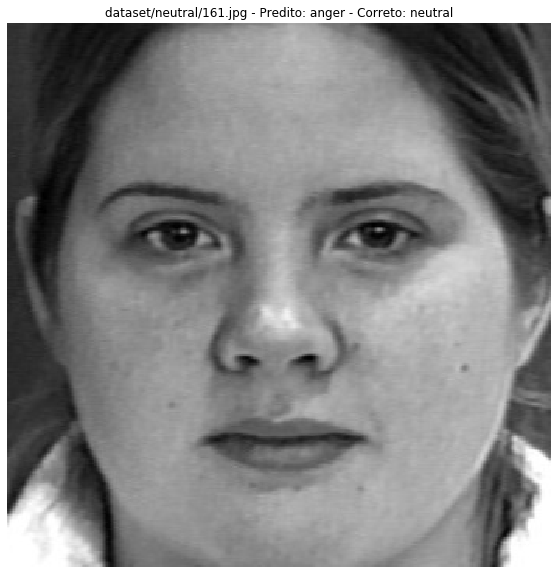

anger: 63.41%
happy: 5.45%
neutral: 18.54%
sadness: 9.84%
surprise: 2.76%


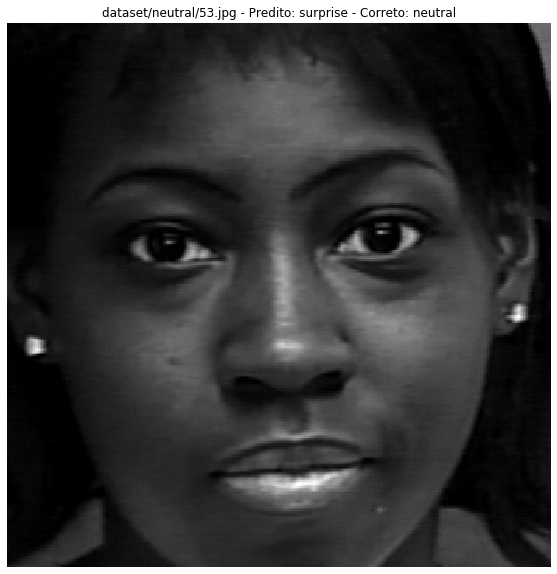

anger: 5.11%
happy: 0.67%
neutral: 8.35%
sadness: 6.51%
surprise: 79.36%


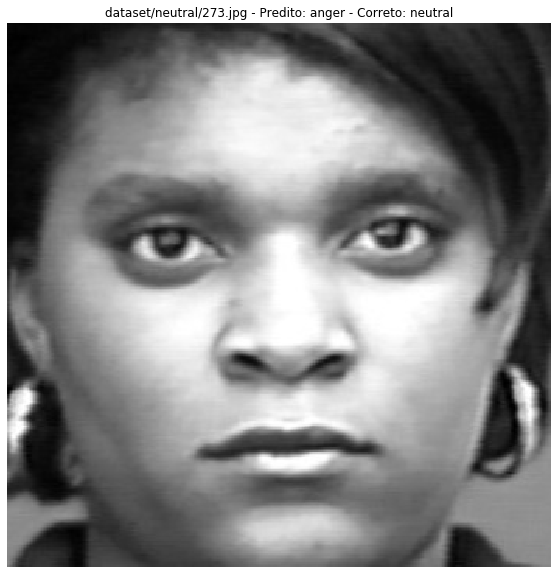

anger: 47.06%
happy: 2.09%
neutral: 32.93%
sadness: 12.49%
surprise: 5.43%


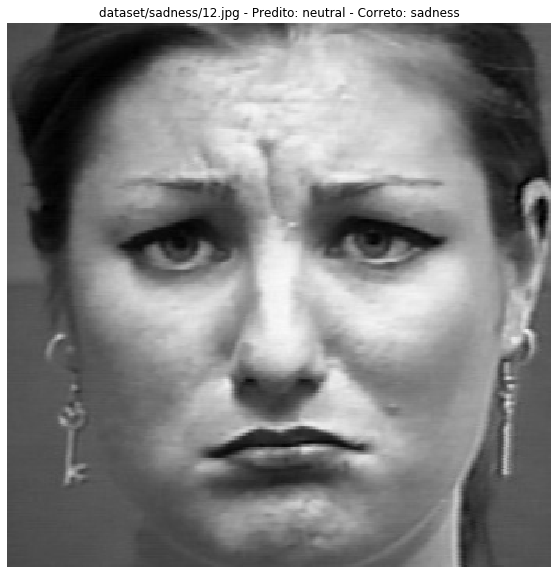

anger: 3.33%
happy: 0.80%
neutral: 82.65%
sadness: 11.29%
surprise: 1.93%


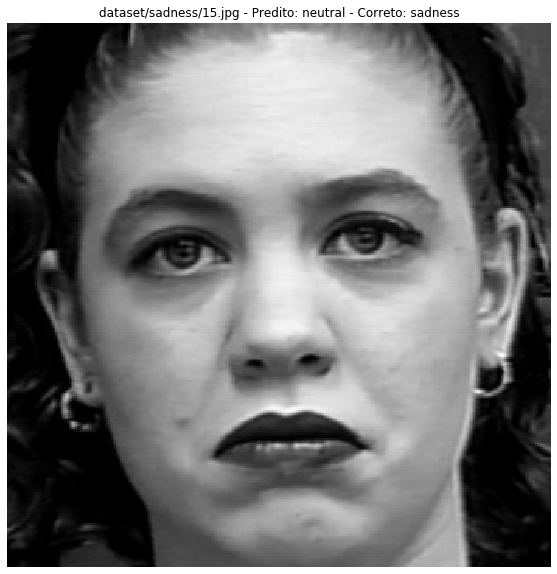

anger: 9.06%
happy: 1.48%
neutral: 49.15%
sadness: 24.73%
surprise: 15.58%


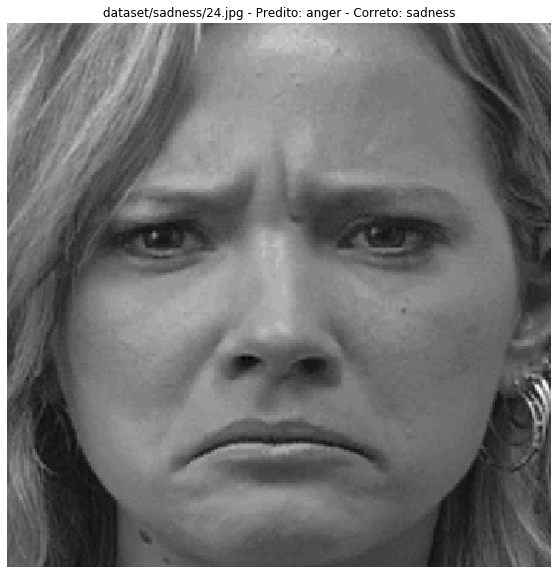

anger: 38.90%
happy: 5.25%
neutral: 25.29%
sadness: 26.77%
surprise: 3.79%


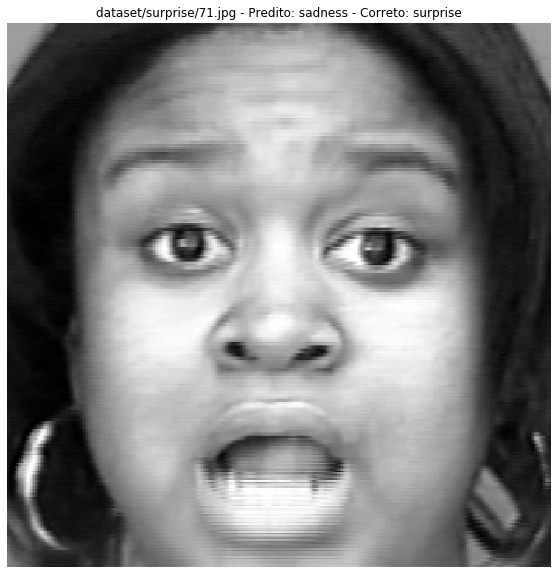

anger: 1.78%
happy: 0.63%
neutral: 12.05%
sadness: 42.85%
surprise: 42.69%


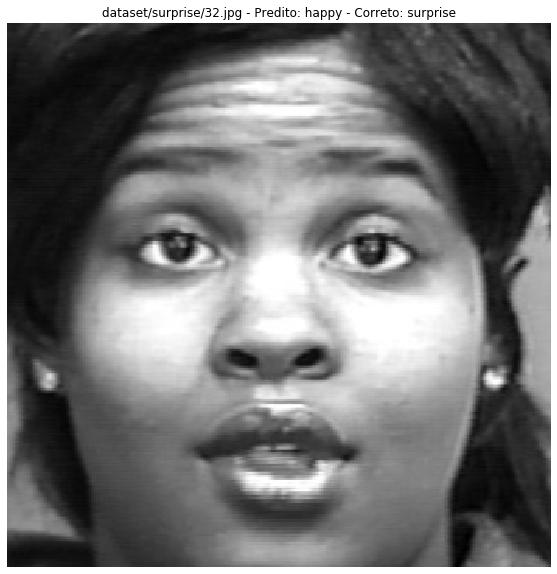

anger: 16.99%
happy: 33.62%
neutral: 19.77%
sadness: 13.55%
surprise: 16.07%


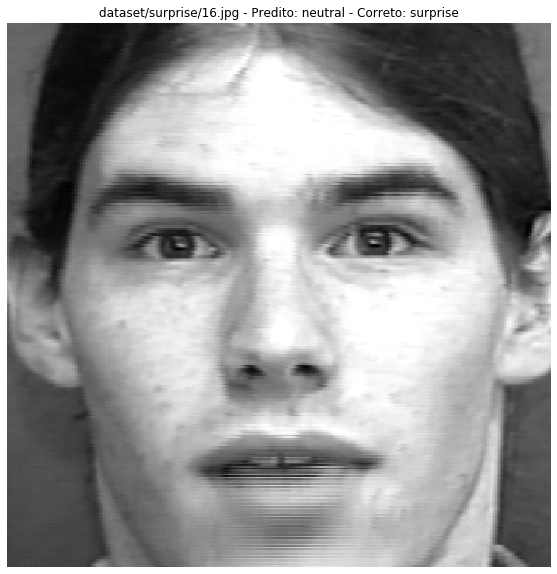

anger: 5.07%
happy: 4.41%
neutral: 67.22%
sadness: 2.57%
surprise: 20.73%


In [43]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

for index, data in enumerate(prediction_data):
    file_name = str(prediction_files[index])
    prediction = clf.predict_proba([data])
    prediction_label = emotions[np.argmax(prediction[0])]
    correct_label = file_name.split('/')[1]
    if(prediction_label != correct_label):
        frame = cv2.imread(file_name)
        plt.rcParams["figure.figsize"] = (20,10)
        plt.title(file_name + ' - Predito: ' + prediction_label + " - Correto: " + correct_label)
        plt.axis('off')
        plt.imshow(frame,cmap='gray')    
        plt.show()
        for index, value in enumerate(prediction[0]):
            probability_percentage = value * 100
            print(emotions[index] + ": %.2f" % probability_percentage + '%')
        

Fazendo uma análise superficial por cima de cada um dos resultados, é possível entender os erros cometidos pelo algoritmo, em alguns casos o valor do rótulo correto se aproxima muito do valor predito pelo modelo.  
Outros casos o contraste da imagem original, assim como as falhas de captura das fotografias influênciaram no resultado do modelo. Houveram ainda casos onde as expressões feitas pelos participantes do corpus são realmente subjetivas e passíveis de erro até para uma análise de um humano.


# Conclusões gerais
Com base nas análises, foi possível observar a grande dificuldade em trabalhar com rótulos emocionais para classificação de imagens, as imagens da base CK+ apresentam em alguns dos casos baixa resolução e baixo contraste o que certamente dificulta a classificação dos seus resultados.

O autor desse trabalho em particular teve grande dificuldade em lidar inicialmente com a base de dados oferecida pois durante o tutorial, Paul van Gent não descreve de maneira clara e objetiva os passos necessários para realizar a limpeza dos datasets do CK+ e seus scripts não apresentam boas práticas de desenvolvimento de software de um modo geral (e.g. criação de diretórios inexistentes, necessidade de realizar uma limpeza manual do dataset de imagens neutras, etc). 

Uma possível melhoria seria a utilização de outras fontes de dados para treinamento do modelo tais como o FER2013, como estas bases oferecem DataSets em formatos diferentes dos apresentado no CK+, seria necessário aplicar o mesmo passo a passo do tutorial de Paul van Gent para realizar a detecção dos pontos característicos da face destas bases e utilizá-los no treinamento em conjunto dos dados utilizados nesta atividade.